In [2]:
def minmax(x):
    """min max normalizes the given array"""
    return (x - np.min(x))/(np.max(x)-np.min(x))

def make_noise(num_traces=100,num_samples=4999):
    """Creates a noise trace used in generating spike rasters.

    Parameters
    ----------
    num_traces : int, optional
        number of noise traces to create (first dimension), by default 100
    num_samples : int, optional
        length of the trace (second dimension), by default 4999

    Returns
    -------
    np.array
        noise trace
    """    
    B = [0.049922035, -0.095993537, 0.050612699, -0.004408786]
    A = [1, -2.494956002,   2.017265875,  -0.522189400]
    invfn = np.zeros((num_traces,num_samples))
    for i in np.arange(0,num_traces):
        wn = np.random.normal(loc=1,
 			   scale=0.5,size=num_samples+2000)
        invfn[i,:] = minmax(ss.lfilter(B, A, wn)[2000:])+0.5                             # Create '1/f' Noise
    return invfn

def make_rhythmic_inh(writer, num_traces=100,T=1,DoM=0.1,f=8,P=0,C=[10.0,1.0],fs=1000):
    """Creates a sin wave trace used in generating spike rasters.

    Parameters
    ----------
    num_traces : int, optional
        number of noise traces to create (first dimension), by default 100
    T : int, optional
        length of the trace in seconds (second dimension), by default 5000
    DoM : float, optional
        depth of modulation = A/(A+C), by default 0.1
    f : int, optional
        frequency of sin wave in Hz, by default 8
    P : int, optional
        phase of sin wave, by default 0
    C : List, optional
        mean and std of offset (i.e. firing rate), by default [10.0, 1.0]

    Returns
    -------
    np.array
        sin wave trace
    """
    
    t = np.arange(T * fs) / fs
    fn = np.zeros((num_traces,T * fs))
    for i in np.arange(0,num_traces):
        offset = np.random.normal(C[0],C[1])
        A = offset/((1/DoM)-1)
        fn[i,:] = A*np.sin((2 * np.pi * f * t)+P) + offset
        
        rateProf=fn[i,:]
        rateProf[rateProf<0] = 0#Can't have negate firing rates.
    
        normRateProf = rateProf


        rate_temp=[];simSpks_temp=[]

        rate_temp = normRateProf

        numbPoints = scipy.stats.poisson(rate_temp/1000).rvs()#Poisson number of points

        simSpks=np.where(numbPoints>0)[0]
        
        writer.append_repeat(ds = "node_ids", val=i, N=len(simSpks))
        writer.append_ds(simSpks, "timestamps")
    return fn

class SonataWriter:
    """Class used to dynamically writing spike rasters to an h5 file.

    Attributes
    ----------
    file : h5py.File
        file object being worked on
    group : h5py.Group
        gropu where the datasets reside
    datasets : dict
        datasets that are saved to the file

    Methods
    -------
    append_ds(vals, ds)
        appends the given values to the end of the given dataset
    append_repeat(ds, val, N)
        appends the given value N times to the end of the given dataset
    close()
        close the h5py file
    """
    def __init__(self, f_name, groups, datasets, types):
        """
        Parameters
        ----------
        f_name : str
            name of file location
        groups : list
            list of group names (str) that are layered into the h5py file
            in the order given.
        datasets : list
            list of dataset names (str)
        types : list
            list of data types that corresponds to the datasets list
        """        
        self.file = h5py.File(f_name, 'w')

        self.group = self.file
        for group in groups:
            self.group = self.group.create_group(group)

        self.datasets = {}
        for i, ds in enumerate(datasets):
            self.datasets[ds] = self.group.create_dataset(ds, data=[], dtype=types[i], chunks=True, maxshape=(None,))

    def append_ds(self, vals, ds):
        """appends the given values to the end of the given dataset

        Parameters
        ----------
        vals : list
            list of values to be appended to the dataset
        ds : str
            key of the dataset to append to
        """        
        length = len(self.datasets[ds])
        self.datasets[ds].resize((length + len(vals), ))
        self.datasets[ds][length:] = vals

    def append_repeat(self, ds, val, N):
        """appends the given value N times to the end of the given dataset

        Parameters
        ----------
        ds : str
            key of the dataset to append to
        val : [type]
            value to be appended N times
        N : int
            number of vals to append to the dataset
        """        
        self.append_ds([val for i in range(N)], ds)

    def close(self):
        """Closes the h5py File
        """        
        self.file.close()

In [3]:
writer = SonataWriter('rhythmic_inh.h5', ["spikes", "prox_inh_stim"], ["timestamps", "node_ids"], [np.float, np.int])
f = make_rhythmic_inh(writer)

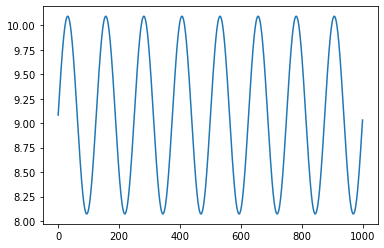

In [4]:
plt.plot(f[0,:])

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import h5py
import scipy.signal as ss

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-8atlukch because the default path (/home/qs/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [95]:
DoM = .01
A = C/((1/DoM)-1)
f = 8
t = np.arange(0,60,.001)
P = 0
C = 10
W = A*np.sin(f*t+P) + C

(0.0, 10.0)

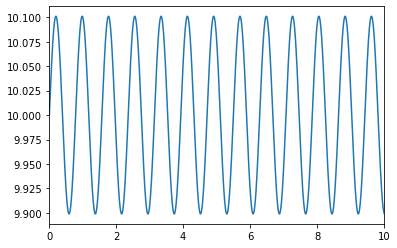

In [98]:
plt.plot(t,W)
plt.xlim(0,10)

In [51]:
rateProf=W
rateProf[rateProf<0] = 0#Can't have negate firing rates.
    
normRateProf = rateProf

numUnits = 10
L = []
for i in np.arange(0,numUnits):
    rate_temp=[];simSpks_temp=[]

    rate_temp = normRateProf
    #rate_temp = normRateProf*dist()

    numbPoints = scipy.stats.poisson(rate_temp/1000).rvs()#Poisson number of points

    simSpks=np.where(numbPoints>0)[0]
    L.append(simSpks)

In [52]:
flat_list = [item for sublist in L for item in sublist]

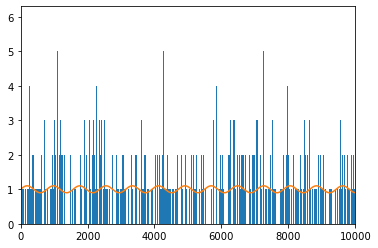

In [53]:
plt.hist(flat_list,bins=np.arange(0,60000,10))
plt.plot(np.arange(0,60000),W-C+1)
plt.xlim(0,10000)
plt.show()

(10000.0, 20000.0)

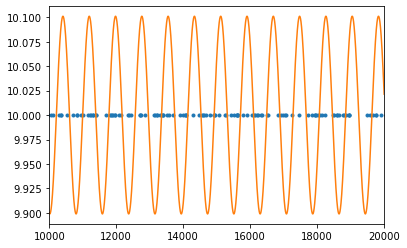

In [54]:
plt.plot(simSpks, 10*np.ones((simSpks.shape[0],)), '.')
plt.plot(np.arange(0,60000),W)
plt.xlim(10000,20000)